## Sources
JAX documentation (general): https://jax.readthedocs.io/en/latest/index.html 

JAX example MLP training on MNIST (has served as the template for this notebook): https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html 

JAX autograd feature: https://jax.readthedocs.io/en/latest/automatic-differentiation.html

Paper on CNNs (particularly important was the part on representing the weights of a conv layer as a sparse matrix mainly on p.20): <br>
_A guide to convolution arithmetic for deep learning_: https://arxiv.org/pdf/1603.07285 

In [14]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax
import pickle
import matplotlib.pyplot as plt

## General idea
The possibility to represent a conv layer as a sparse matrix - if one would think of the inputs as flattened vectors and imagine the connections between individual neurons in a CNN - is at the core of this project. Once this central conversion step is implemented, a CNN can be largely trained in the same way as a fully connected MLP in JAX.

For reasons of simplicity and minimal potential performance benefits on this demo use case, bias has been left aside for the conv layers and has only been applied to the fully connected onces. Advanced techniques like layer or batch normalization are also not needed here and left out for this JAX CNN implementation demo since the goal and scope of the project has been to set up a working training and being able to train and evaluate a well performing model, which has been achieved.

## Helper functions

In [8]:
def create_weight_matrix(kernel_size, image_dim, key, num_kernels=1, mean=0.0, stddev=1.0, input_channels=1):
    """
    Creates a weight matrix for multiple convolutional kernels applied to a flattened image.

    Parameters:
    kernel_size (int): The size of the kernel (assumed to be square).
    image_dim (int): The dimension of one side of the square input image.
    key (jax.random.PRNGKey): A random key for generating random numbers.
    num_kernels (int): Number of kernels.
    mean (float): Mean of the Gaussian distribution.
    stddev (float): Standard deviation of the Gaussian distribution.

    Returns:
    jax.numpy.ndarray: The stacked weight matrices.
    """
    output_dim = image_dim - kernel_size + 1
    num_pixels = image_dim * image_dim
    output_pixels = output_dim * output_dim

    # Initializing the tensor to hold weight matrices for all kernels
    all_weight_matrices = jnp.zeros((num_kernels, input_channels, output_pixels, num_pixels))

    for k in range(num_kernels):
        # Generating a new random key for each kernel to ensure different random values
        key, subkey = random.split(key)
        
        # Generating random Gaussian kernel weights
        kernel_weights = random.normal(subkey, (input_channels, kernel_size, kernel_size)) * stddev + mean

        weight_matrix = jnp.zeros((input_channels, output_pixels, num_pixels))

        # Iterating over each position in the output matrix
        for n_channel in range(input_channels):
            for i in range(output_dim):
                for j in range(output_dim):
                    row_idx = i * output_dim + j

                    for ki in range(kernel_size):
                        for kj in range(kernel_size):
                            col_idx = (i + ki) * image_dim + (j + kj)
                            weight_matrix = weight_matrix.at[n_channel, row_idx, col_idx].set(kernel_weights[n_channel, ki, kj])

        # Storing the weight matrix for this kernel
        all_weight_matrices = all_weight_matrices.at[k].set(weight_matrix)

    return all_weight_matrices

# Example usage
kernel_size = 3
image_dim = 4
num_kernels = 2 
input_channels = 2
key = random.PRNGKey(0)

weight_matrices = create_weight_matrix(kernel_size, image_dim, key, num_kernels, input_channels=input_channels)

print("Weight Matrices for Multiple Kernels:")
print(weight_matrices)


Weight Matrices for Multiple Kernels:
[[[[ 0.0587435  -0.81615645  0.2534565   0.         -0.15812145
    -1.304995   -2.1015406   0.         -1.0378758   1.0157981
     0.23806651  0.          0.          0.          0.
     0.        ]
   [ 0.          0.0587435  -0.81615645  0.2534565   0.
    -0.15812145 -1.304995   -2.1015406   0.         -1.0378758
     1.0157981   0.23806651  0.          0.          0.
     0.        ]
   [ 0.          0.          0.          0.          0.0587435
    -0.81615645  0.2534565   0.         -0.15812145 -1.304995
    -2.1015406   0.         -1.0378758   1.0157981   0.23806651
     0.        ]
   [ 0.          0.          0.          0.          0.
     0.0587435  -0.81615645  0.2534565   0.         -0.15812145
    -1.304995   -2.1015406   0.         -1.0378758   1.0157981
     0.23806651]]

  [[ 0.44727293  0.87157464 -0.43935215  0.         -0.5539933
    -0.7797317  -0.44700328  0.          1.4288545   0.02351617
     0.67991376  0.          0.    

## Model initilization

In [9]:
def random_conv_params(kernel_size, input_dim, num_kernels, input_channels, key, scale=1e-2):
    """
    Randomly initializes weights for a convolutional layer.

    Parameters:
    kernel_size (int): The size of the kernel (assumed to be square).
    input_dim (int): The dimension of one side of the square input image.
    num_kernels (int): Number of kernels.
    key (jax.random.PRNGKey): A random key for generating random numbers.
    scale (float): Scaling factor for weights.

    Returns:
    jax.numpy.ndarray: The stacked weight matrices for convolutional kernels.
    """
    weight_matrices = create_weight_matrix(kernel_size, input_dim, key, num_kernels, input_channels=input_channels) * scale
    return weight_matrices

def random_dense_params(m, n, key, scale=1e-2):
    """
    Randomly initializes weights and biases for a dense neural network layer.

    Parameters:
    m (int): Number of input units.
    n (int): Number of output units.
    key (jax.random.PRNGKey): A random key for generating random numbers.
    scale (float): Scaling factor for weights.

    Returns:
    Tuple[jax.numpy.ndarray, jax.numpy.ndarray]: The weights and biases for the dense layer.
    """
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

def init_network_params(layer_defs, key):
    """
    Initializes all layers for a CNN (conv & dense layers) with given layer definitions.

    Parameters:
    layer_defs (list of dict): Definitions of each layer in the network. 
                               Each dict should have 'type' key ('conv' or 'dense') 
                               and corresponding parameters.
    key (jax.random.PRNGKey): A random key for generating random numbers.

    Returns:
    list: A list of initialized parameters for each layer.
    """
    keys = random.split(key, len(layer_defs))
    params = []

    for layer_def, k in zip(layer_defs, keys):
        print("Next layer")
        if layer_def['type'] == 'conv':
            params.append(random_conv_params(layer_def['kernel_size'], 
                                             layer_def['input_dim'], 
                                             layer_def['num_kernels'],
                                             layer_def['input_channels'],  
                                             k))
        elif layer_def['type'] == 'dense':
            params.append(random_dense_params(layer_def['input_dim'], 
                                              layer_def['output_dim'], 
                                              k))
    return params

# Defining the network architecture for MNIST using a combination of conv & dense layers
layer_defs = [
    {'type': 'conv', 'kernel_size': 3, 'input_dim': 28, 'num_kernels': 4, 'input_channels': 1},
    {'type': 'conv', 'kernel_size': 3, 'input_dim': 26, 'num_kernels': 8, 'input_channels': 4},  # input_dim reduces due to no padding
    {'type': 'dense', 'input_dim': 8 * 24 * 24, 'output_dim': 128},  # input_dim changes according to conv layer outputs
    {'type': 'dense', 'input_dim': 128, 'output_dim': 10}
]
key = random.PRNGKey(0)
params = init_network_params(layer_defs, key)

print("Network Parameters:")
for i, p in enumerate(params):
    if len(params) !=2:
        print(f"Layer {i}:")
        print(p[0].shape, p[1].shape)
    else:
        print(f"Layer {i}:")
        print(p.shape)

Next layer
Next layer
Next layer
Next layer
Network Parameters:
Layer 0:
(1, 676, 784) (1, 676, 784)
Layer 1:
(4, 576, 676) (4, 576, 676)
Layer 2:
(128, 4608) (128,)
Layer 3:
(10, 128) (10,)


## Forward pass

Designing the forward pass logic

In [12]:
from jax.scipy.special import logsumexp

def relu(x):
  return jnp.maximum(0, x)

def predict(params, fm_in):
  # per-example predictions
  activations = jnp.array([fm_in])
  for param_set in params[:-1]:
    if len(param_set) == 2: # means if layer == dense, because only those have 2 params (weight, bias)
      activations = activations.flatten() # flattening for transition from conv to fc layers (no effect anyways otherwise)
      w, b = param_set
      print(w.shape, activations.shape)
      outputs = jnp.dot(w, activations) + b # calculating layer output

    else:
      weight_matrix = param_set
      num_kernels = weight_matrix.shape[0]
      print(weight_matrix.shape, activations.shape)

      feature_maps_out = []
      for k in range(num_kernels): # calculating output feature map for one kernel at a time
        kernel_weight_tensor = weight_matrix[k]
        kernel_depth = kernel_weight_tensor.shape[0]
        feature_map = jnp.zeros(kernel_weight_tensor.shape[1]) # defining empty feature map for partial construction in loop
        for d in range(kernel_depth): # looping over the kernel layers (depth) to construct output feature map step by step with partials
            weight = kernel_weight_tensor[d]  # Getting the weight matrix corresponding to the d-th input feature map
            feature_map_partial = jnp.dot(weight, activations[d])  # Dot product between weight and the d-th input feature map
            feature_map += feature_map_partial  # Summing up the partial results to form the complete feature map
        feature_maps_out.append(feature_map) # Appending the output feature map to the list of all feature maps resulting from the different kernels

      outputs = jnp.array(feature_maps_out)

    activations = relu(outputs)
    print(activations.shape)
  
  # final layer
  final_w, final_b = params[-1]
  logits = jnp.dot(final_w, activations) + final_b
  print(logits)
  return jnp.exp(logits - jax.scipy.special.logsumexp(logits)) # softmax output

Testing the forward pass

In [19]:
# This works on single examples
random_flattened_image = random.normal(random.key(1), (28 * 28,))
preds = predict(params, random_flattened_image)
print(preds.shape)

(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
(10,)


JAX batch handling with vmap (taken from docs)

In [18]:
# Doesn't work with a batch
random_flattened_images = random.normal(random.key(1), (10, 28 * 28))
try:
  preds = predict(params, random_flattened_images)
except TypeError:
  print('Invalid shapes!')

(4, 1, 676, 784) (1, 10, 784)
Invalid shapes!


In [21]:
# Let's upgrade it to handle batches using `vmap`

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

# `batched_predict` has the same call signature as `predict`
batched_preds = batched_predict(params, random_flattened_images)
print(batched_preds.shape)

(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
(10, 10)


In [26]:
params

[Array([[[[-0.01062579, -0.00319807,  0.01910353, ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        , -0.01062579, -0.00319807, ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        , -0.01062579, ...,  0.        ,
            0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        , ...,  0.00571147,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        , ..., -0.01330986,
            0.00571147,  0.        ],
          [ 0.        ,  0.        ,  0.        , ..., -0.00881463,
           -0.01330986,  0.00571147]]],
 
 
        [[[ 0.00060935, -0.02070534,  0.00164051, ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.00060935, -0.02070534, ...,  0.        ,
            0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.00060935, ...,  0.        ,
            0.        ,  0.        ],
          ...,
          

## Utility and loss functions

In [47]:
step_size = 0.01
num_epochs = 10
batch_size = 128

In [8]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)
  
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

def loss(params, images, targets):
  preds = batched_predict(params, images)
  return -jnp.mean(preds * targets)

@jit
def update(params, x, y):
  grads = grad(loss)(params, x, y)
  updated_weights = []
  for edges, updates in zip(params, grads):
    if len(edges)==2: # is the case for dense layers since they have weights & biases
      (w,b) = edges
      (dw, db) = updates
      updated_weights.append((w - step_size * dw, b - step_size * db))
    else: # only updating weights in conv layers
      (w) = edges
      (dw) = updates
      updated_weights.append((w - step_size*dw))
  return updated_weights

## Data Loading with `tensorflow/datasets`

In [9]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
# tfds.load returns tf.Tensors (or tf.data.Datasets if batch_size != -1)
# You can convert them to NumPy arrays (or iterables of NumPy arrays) with tfds.dataset_as_numpy
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_images = jnp.reshape(train_images, (len(train_images), num_pixels))
train_labels = one_hot(train_labels, num_labels)

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_images = jnp.reshape(test_images, (len(test_images), num_pixels))
test_labels = one_hot(test_labels, num_labels)

In [10]:
print('Train:', train_images.shape, train_labels.shape)
print('Test:', test_images.shape, test_labels.shape)

Train: (60000, 784) (60000, 10)
Test: (10000, 784) (10000, 10)


## Training Loop

In [51]:
import time
train_accs = []
test_accs = []

def get_train_batches():
  # as_supervised=True gives us the (image, label) as a tuple instead of a dict
  ds = tfds.load(name='mnist', split='train', as_supervised=True, data_dir=data_dir)
  # You can build up an arbitrary tf.data input pipeline
  ds = ds.batch(batch_size).prefetch(1)
  # tfds.dataset_as_numpy converts the tf.data.Dataset into an iterable of NumPy arrays
  return tfds.as_numpy(ds)

for epoch in range(num_epochs):
  start_time = time.time()
  for x, y in get_train_batches():
    x = jnp.reshape(x, (len(x), num_pixels))
    y = one_hot(y, num_labels)
    params = update(params, x, y)
  epoch_time = time.time() - start_time

  train_acc = accuracy(params, train_images, train_labels)
  test_acc = accuracy(params, test_images, test_labels)
  train_accs.append(train_acc)
  test_accs.append(test_accs)
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
Epoch 0 in 47.53 sec
Training set accuracy 0.907200038433075
Test set accuracy 0.9084999561309814
(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
Epoch 1 in 45.51 sec
Training set accuracy 0.9171333312988281
Test set accuracy 0.9188999533653259
(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
Epoch 2 in 46.59 sec
Traini

## Evaluation

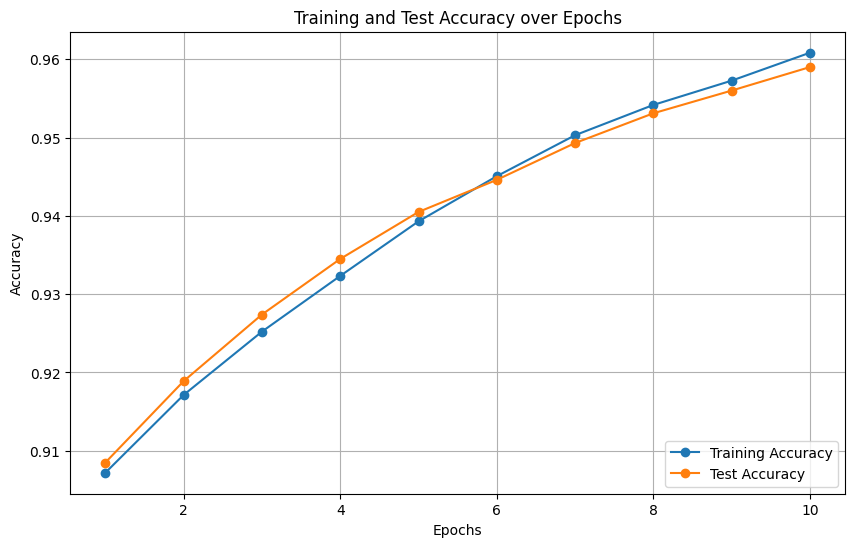

In [4]:
import matplotlib.pyplot as plt

def plot_accuracies(train_accs, test_accs):
    """
    Plots training and test accuracies over epochs.

    Parameters:
    train_accs (list): List of training accuracies recorded after each epoch.
    test_accs (list): List of test accuracies recorded after each epoch.
    """
    epochs = range(1, len(train_accs) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accs, label='Training Accuracy', marker='o')
    plt.plot(epochs, test_accs, label='Test Accuracy', marker='o')

    plt.title('Training and Test Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot the accuracies
plot_accuracies(train_accs, test_accs)


## Saving and loading

In [57]:
def save_model(params, filename="model_params.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(params, f)
    print(f"Model parameters saved to {filename}")
save_model(params)

Model parameters saved to model_params.pkl


In [4]:
def load_model(filename="model_params.pkl"):
    with open(filename, 'rb') as f:
        params = pickle.load(f)
    print(f"Model parameters loaded from {filename}")
    return params

params = load_model("model_params.pkl")

Model parameters loaded from model_params.pkl


## Interactive testing

(4, 1, 676, 784) (1, 784)
(4, 676)
(8, 4, 576, 676) (4, 676)
(8, 576)
(128, 4608) (4608,)
(128,)
[-2.8975177 -4.4480453 -2.5694659  2.1310093  2.2737374  0.9376666
 -5.9516797  2.825836   0.5425321  8.510646 ]


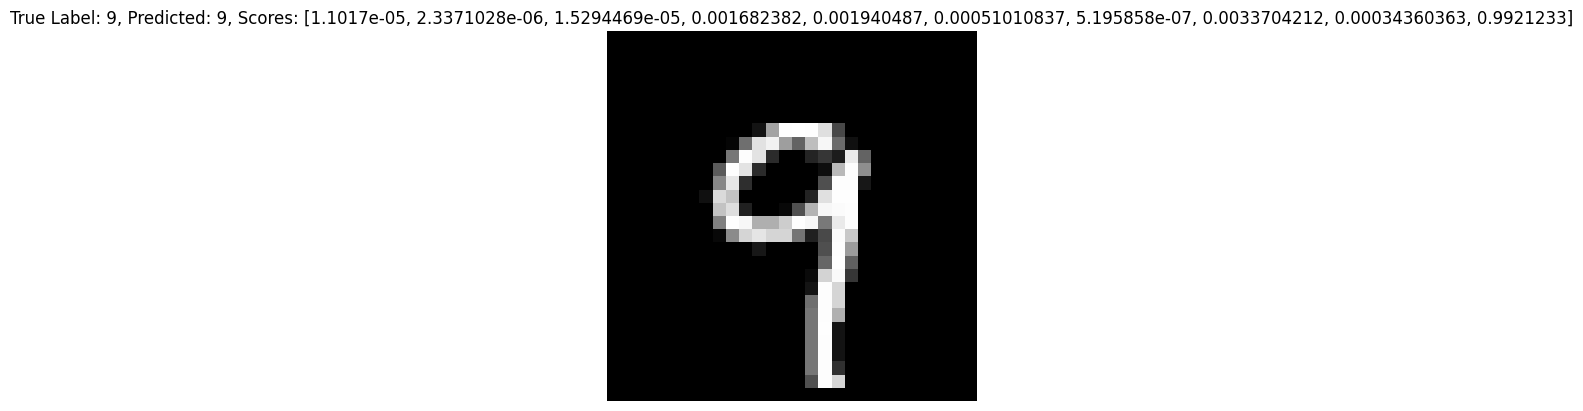

In [15]:
import random
import numpy as np


def sample_predict(params, test_images, test_labels):
    # Selecting a random index
    random_idx = random.randint(0, len(test_images) - 1)

    # Getting the random image and its true label
    image = test_images[random_idx]
    true_label = test_labels[random_idx]

    # Reshaping image if needed
    image = jnp.reshape(image, (-1,))  # Flattening the image if necessary

    # Predicting the output scores
    scores = predict(params, image)

    # Converting to numpy for easier manipulation and plotting
    image = np.reshape(np.array(image), (28, 28))  # Assuming image is 28x28 pixels
    scores = np.array(scores)

    # Plotting the image
    plt.imshow(image, cmap='gray')
    plt.title(f"True Label: {np.argmax(true_label)}, Predicted: {scores.argmax()}, Scores: {list(scores)}")
    plt.axis('off')
    plt.show()

# Example usage:
sample_predict(params, test_images, test_labels)